# Lab : Generative models at the lexical level

## Objectives:

Explore the two generative models seen in class (Naïve Bayes for classification, Latent Dirichlet Allocation for topic modeling) by applying them to a relatively small classification dataset - **20NewsGroup** - try to  look at how they perform on the classification task and understand how to interpret the topic models. 
1. Pre-process the data: clean it, understand the various possibilities for pre-processing steps.
2. Obtain representations: first, symbolic document representations: **BoW**, then **TF-IDF**
    - We will first implement our functions for doing so, then use ```sklearn```. 
3. Perform classification:
    - We will first implement our function for Naïve Bayes, then use ```sklearn```.
    - We will search for the best hyper-parameters using ```pipeline```.
4. Perform topic modeling:
    - We will quickly compare LSA and LDA and try to interpret them. 
    - We will implement simple metrics and look for the best hype-parameters maximizing them.

## Necessary dependancies

We will need the following packages:
- The Natural Language Toolkit : http://www.nltk.org/install.html
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html

In [3]:
import os.path as op
import re 
import numpy as np
from pprint import pprint

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [4]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
ng_train = fetch_20newsgroups(subset='train',
                              remove=('headers', 'footers', 'quotes')
                              )

In [6]:
pprint(dir(ng_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [7]:
pprint(ng_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Example of one document:

In [8]:
pprint(ng_train.data[0])
print("Target: ", ng_train.target_names[ng_train.target[0]])

('I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.')
Target:  rec.autos


## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words).

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import unidecode
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADAMA\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def clean_text(text: str,
               rm_numbers=True,
               rm_punct=True,
               rm_stop_words=True,
               rm_short_words=True):
    # make lowercase
    text = text.lower()

    # remove URLs
    URL_PATTERN = re.compile(r'\b(?:https?://|www\.)\S+\b', flags=re.IGNORECASE)
    text = URL_PATTERN.sub('', text)

    # remove domain names
    DOMAIN_PATTERN = re.compile(r'\b(?:[a-z0-9-]+\.)+[a-z]{2,}\b', flags=re.IGNORECASE)
    text = DOMAIN_PATTERN.sub('', text)
    
    # remove email addresses
    EMAIL_PATTERN = re.compile(r'\b[a-z0-9._%+-]+@(?:[a-z0-9-]+\.)+[a-z]{2,}\b', flags=re.IGNORECASE)
    text = EMAIL_PATTERN.sub('', text)
                               
    # remove punctuation
    if rm_punct:
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))

    # remove numbers
    if rm_numbers:
        text = re.sub(r'\d+', '', text)

    # replace linebreaks and strip
    text = re.sub(r'\n+', ' ', text)
    text = text.strip()

    # remove stopwords
    if rm_stop_words:
        stop_words = set(stopwords.words('english'))
        # Apply tokenization and filter stop words
        tokens = word_tokenize(text)
        text_list = [token for token in tokens if token not in stop_words]
        text = ' '.join(text_list)
        
    # remove short words
    if rm_short_words:
        # Apply tokenization and filter short words
        tokens = word_tokenize(text)
        text_list = [token for token in tokens if len(token) >= 3]
        # Put text back together
        text = ' '.join(text_list)
    
    return text

In [11]:
pprint(clean_text(ng_train.data[0]))

('wondering anyone could enlighten car saw day door sports car looked late '
 'early called bricklin doors really small addition front bumper separate rest '
 'body know anyone tellme model name engine specs years production car made '
 'history whatever info funky looking car please mail')


The dataset contains 20 classes. However, **some of them are pretty close together. We aggregate them into 6 semantically coherent classes** which should not be easier to distinguish:

In [12]:
def aggregate_labels(label):
    # comp
    if label in [1,2,3,4,5]:
        new_label = 0
    # rec
    if label in [7,8,9,10]:
        new_label = 1
    # sci
    if label in [11,12,13,14]:
        new_label = 2
    # misc 
    if label in [6]:
        new_label = 3
    # pol
    if label in [16,17,18]:
        new_label = 4
    # rel
    if label in [0,15,19]:
        new_label = 5
    return new_label

We check that **we don't have any empty document**:

<div class='alert alert-block alert-info'>
            Code:</div>

In [13]:
ng_train_text = [clean_text(text) for text in ng_train.data]
ng_train_labels = [aggregate_labels(label) for label in ng_train.target]

In [14]:
ng_test = fetch_20newsgroups(subset='test',
                             remove=('headers', 'footers', 'quotes')
                            )

ng_test_text = [clean_text(text) for text in ng_test.data]
ng_test_labels = [aggregate_labels(label) for label in ng_test.target]

We may apply a **lemmatizer**. We can get one from ```NLTK```.
If we want it to work, we need the **part-of-speech** information of the word: 
- *Meeting* will not have the same lemma if it's a verb or a noun ! 
    
For that, we can use ```NLTK``` tools:
- ```word_tokenize``` to cut the document into tokens,
- ```pos_tag``` to obtain part-of-speech tags,
- ```get_wordnet_pos``` is a mapping function that will allow us to get the full POS designation to be used by the lemmatizer.
    

In [15]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

In [16]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default solution

def preprocess_and_lemmatize(text):   
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return " ".join(lemmatized)

In [17]:
lemmatized_doc = preprocess_and_lemmatize(clean_text(ng_train.data[0]))
pprint(lemmatized_doc)

('wonder anyone could enlighten car saw day door sport car look late early '
 'call bricklin door really small addition front bumper separate rest body '
 'know anyone tellme model name engine spec year production car make history '
 'whatever info funky look car please mail')


<div class='alert alert-block alert-info'>
            Code:</div>

In [18]:
ng_train_text_lemma = [preprocess_and_lemmatize(text) for text in ng_train_text]

In [19]:
from sklearn.model_selection import train_test_split

ng_train_text_splt, ng_val_text, ng_train_labels_splt, ng_val_labels = train_test_split(ng_train_text_lemma, ng_train_labels, test_size=.2)

## 2 - Document representations 

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to better understand:

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [21]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).
<div class='alert alert-block alert-info'>
            Code:</div>

In [34]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    # Obtain the set of all words present in the data
    all_words = set()
    for text in texts:
        all_words.update(text.split())
    # Use it to create the vocabulary
    vocabulary = dict(zip(all_words, range(len(all_words))))
    # Create the term document matrix
    counts = np.zeros((len(texts), len(all_words)))
    # Fill it 
    for i, text in enumerate(texts):
        for word in text.split():
            counts[i, vocabulary[word]] += 1
    
    return vocabulary, counts

In [36]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'the': 0, 'boulevard': 1, 'I': 2, 'down': 3, 'walked': 4, 'avenue': 5, 'city': 6, 'ran': 7, 'walk': 8}
[[1. 1. 1. 2. 1. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 1. 0. 0. 1. 0. 1.]
 [2. 0. 1. 1. 0. 1. 0. 0. 1.]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:

In [24]:
val_corpus = ['I walked up the street']
Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]])

Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary ! 
<div class='alert alert-block alert-info'>
            Code:</div>

In [25]:
def count_words(texts, voc = None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    if voc == None:
        all_words = set()
        for text in texts:
            all_words.update(text.split())
        vocabulary = dict(zip(all_words, range(len(all_words))))
    else:
        vocabulary = voc
    counts = np.zeros((len(texts), len(vocabulary)))    
    for i, text in enumerate(texts):
        for word in text.split():
            counts[i, vocabulary[word]] += 1
    return vocabulary, counts

In [26]:
voc, train_bow = count_words(ng_train_text_splt)
print(train_bow.shape)

(9051, 61082)


Compare with the ```sklearn``` version:

In [27]:
vectorizer = CountVectorizer()
Bow = vectorizer.fit_transform(ng_train_text_splt)
train_bow_sk = Bow.toarray()
print(train_bow_sk.shape)

(9051, 61079)


<div class='alert alert-block alert-warning'>
            Question:</div>
            
Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What ```CountVectorizer``` arguments allows to avoid the issue ? 

**Answer :**

In [28]:
vectorizer = CountVectorizer(min_df=2, max_df=0.85)
Bow = vectorizer.fit_transform(ng_train_text_splt)
train_bow_sk = Bow.toarray()
print(train_bow_sk.shape)

(9051, 24341)


In what comes next, we will mainly use the ```min_df``` and ```max_df``` arguments to affect pre-processing.

In [29]:
val_bow = vectorizer.transform(ng_val_text).toarray()
print(val_bow.shape)

(2263, 24341)


Let's first look at the most frequent words. This will require some simple array manipulation:
- Retrieving the sum of all word occurences across documents,
- Sorting words according to their frequency,
- Plotting an histogram for the top words, using the count as value and the word as legend.

How can that influence our pre-processing ? 

<div class='alert alert-block alert-info'>
            Code:</div>

In [53]:
frequency = train_bow_sk.sum(axis=0) # Total count of each word in the data
top_words = np.argsort(frequency)[::-1] # Indexes sorted by frequency

In [54]:
print(frequency)
print(top_words[:10])

[ 3 22  2 ...  6  2  2]
[22431 15081 23537 12877  8412 18706 11554 12618 15795 12098]


In [55]:
# Get the vocabulary from the vectorizer using get_feature_names_out()
voc = dict(zip(vectorizer.get_feature_names_out(),range(len(vectorizer.get_feature_names_out()))))

In [56]:
import matplotlib.pyplot as plt

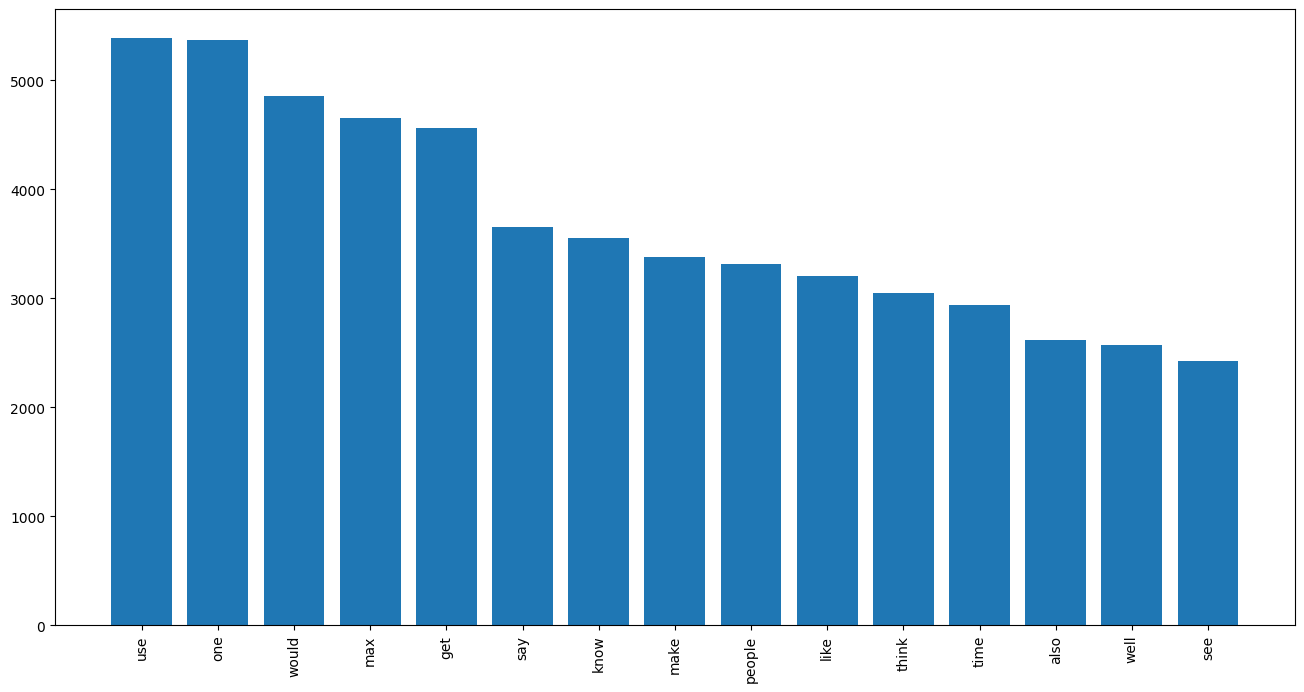

In [57]:
rev_voc = {i: w for w, i in voc.items()} # Reverse vocabulary
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(15), frequency[top_words[:15]])
ax.set_xticks(range(15))
ax.set_xticklabels([rev_voc[i] for i in top_words[:15]], rotation='vertical')
plt.show()

**Improving those representations with TF-DF**: This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 
Implement a function transforming the BOW representations we obtained as output of ```count_words``` into TF-IDF representations:
<div class='alert alert-block alert-info'>
            Code:</div>

In [44]:
from sklearn.preprocessing import normalize

def tfidf_transform(bow):
    """
    Inverse document frequencies applied to our bag-of-words representations
    """
    # IDF
    n_docs = bow.shape[0]
    n_words = bow.shape[1]
    df = np.sum(bow > 0, axis=0)
    idfs = np.log(n_docs / (df + 1))  # +1 to avoid division by zero
    # TF
    tfs = bow / np.sum(bow, axis=1, keepdims=True) 
    tfs = np.nan_to_num(tfs)  # handle division by zero
    
    tf_idf = tfs * np.expand_dims(idfs,axis=0)
    return tf_idf

In [45]:
tfidf = tfidf_transform(train_bow_sk)
print(tfidf.shape)

C:\Users\ADAMA\AppData\Local\Temp\ipykernel_20200\3834431423.py:13: RuntimeWarning: invalid value encountered in divide
  tfs = bow / np.sum(bow, axis=1, keepdims=True)


(9051, 24341)


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [47]:
# Create and fit the vectorizer to the training data
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.85)
Tfidf = tfidf_vectorizer.fit_transform(ng_train_text_splt)
tfidf_sk = Tfidf.toarray()
print(tfidf_sk.shape)

(9051, 24341)


## 3 - Classification with Naive Bayesian 

We will implement a class ```NB``` that should correspond to a **scikit-learn model**. It will contain the following methods:

```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class ```NB```.

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.
<div class='alert alert-block alert-info'>
            Code:</div>

In [58]:
class NB(BaseEstimator, ClassifierMixin):
    # Class arguments allow to use sklearn methods 
    def __init__(self, alpha=1.0):
        # alpha is a smoothing parameter
        self.alpha = alpha

    def fit(self, X, y):
        # Compute the prior probabilities of classes
        n_docs = X.shape[0]
        n_features = X.shape[1]
        classes = np.unique(y)
        log_prior = np.zeros(len(classes))
        log_cond_prob = np.zeros((len(classes), n_features))
        
        # And the conditional probabilities of words given classes
        for idx, c in enumerate(classes):
            X_c = X[y == c]
            # Prior: P(c) = count(c) / total
            log_prior[idx] = np.log(X_c.shape[0] / n_docs)
            # Conditional: P(w|c) = (count(w,c) + alpha) / (sum + alpha * |V|)
            word_counts = np.sum(X_c, axis=0)
            log_cond_prob[idx] = np.log((word_counts + self.alpha) / 
                                         (np.sum(word_counts) + self.alpha * n_features))
        
        # Save them as model attributes
        self.log_prior_ = log_prior
        self.log_cond_prob_ = log_cond_prob
        return self

    def predict(self, X):
        # Do prediction: compute the score of each document

        scores = X @ self.log_cond_prob_.T + self.log_prior_
        # And return the classes maximizing those scores
        pred = np.argmax(scores, axis=1)
        return pred
        
    def score(self, X, y):
        # Return accuracy
        return np.sum(self.predict(X)==y)/len(y)

In [86]:
clf_nb = NB()
clf_nb.fit(train_bow_sk, ng_train_labels_splt)
val_pred = clf_nb.predict(val_bow)

Besides accuracy, we can look at **F1**-measures, and display the *confusion matrix*.

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       544
           1       0.90      0.83      0.86       487
           2       0.79      0.75      0.77       494
           3       0.82      0.53      0.64       123
           4       0.77      0.85      0.81       318
           5       0.81      0.81      0.81       297

    accuracy                           0.81      2263
   macro avg       0.81      0.78      0.79      2263
weighted avg       0.82      0.81      0.81      2263



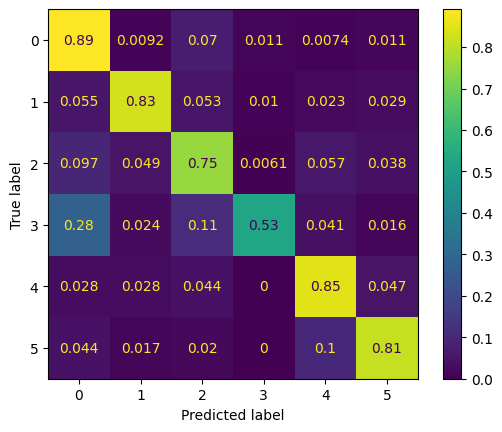

In [88]:
print(classification_report(ng_val_labels, val_pred))
cm = confusion_matrix(ng_val_labels , val_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(6))
disp.plot()
plt.show()

We can also use the scikit-learn ```MultinomialNB```. Experiment on this model too and compare the results.
<div class='alert alert-block alert-info'>
            Code:</div>

In [89]:
from sklearn.naive_bayes import MultinomialNB
# Fit the model on the training data
clf_sk_nb = MultinomialNB(alpha=1.0)
clf_sk_nb.fit(train_bow_sk, ng_train_labels_splt)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [90]:
# Do the prediction and evaluation
val_pred_sk = clf_sk_nb.predict(val_bow)
print(val_pred_sk)

[0 4 0 ... 2 0 1]


We want to **find the best hyper-parameters** for our model: in this case, it will mainly affect the pre-processing.
In what follows, use ```Pipeline``` to perform a series of quick experiments, and use the validation data to check which set of representations (depending on ```min_df```, ```max_df``` and using ```tf-idf``` or not):
<div class='alert alert-block alert-info'>
            Code:</div>

In [91]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline

In [92]:
pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("clf", MultinomialNB())
])

pipeline_tfidf = Pipeline([
    ("vect", CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ("clf", MultinomialNB())
])

In [93]:
min_dfs = [1, 2, 3, 5, 10]
max_dfs = [0.5, 0.6, 0.7, 0.85, 1.0]

# Test the model for those pre-processing hyper-parameters
best_min_df = 1
best_min_df_tfidf = 1
best_max_df = 0.5
best_max_df_tfidf = 0.5
best_acc = 0
best_acc_tfidf = 0
for min_df in min_dfs:
    for max_df in max_dfs:
        print(f"min_df={min_df}, max_df={max_df}")
        pipeline.set_params(vect__min_df=min_df, vect__max_df=max_df)
        pipeline.fit(ng_train_text_splt, ng_train_labels_splt)
        val_pred = pipeline.predict(ng_val_text)
        acc = accuracy_score(ng_val_labels, val_pred)
        f1 = f1_score(ng_val_labels, val_pred, average='weighted')
        print("BoW")
        print("Accuracy_score: ", acc)
        print("F1_score: ", f1)
        if acc > best_acc:
            best_acc = acc
            best_min_df = min_df
            best_max_df = max_df
        
        pipeline_tfidf.set_params(vect__min_df=min_df, vect__max_df=max_df)
        pipeline_tfidf.fit(ng_train_text_splt, ng_train_labels_splt)
        val_pred_tfidf = pipeline_tfidf.predict(ng_val_text)
        acc_tfidf = accuracy_score(ng_val_labels, val_pred_tfidf)
        f1_tfidf = f1_score(ng_val_labels, val_pred_tfidf, average='weighted')
        print("TF-IDF")
        print("Accuracy_score: ", acc_tfidf)
        print("F1_score: ", f1_tfidf)
        if acc_tfidf > best_acc_tfidf:
            best_acc_tfidf = acc_tfidf
            best_min_df_tfidf = min_df
            best_max_df_tfidf = max_df

print(f"Best BoW: min_df={best_min_df}, max_df={best_max_df}, acc={best_acc}"   )
print(f"Best TF-IDF: min_df={best_min_df_tfidf}, max_df={best_max_df_tfidf}, acc={best_acc_tfidf}"   )

min_df=1, max_df=0.5
BoW
Accuracy_score:  0.8068935041979673
F1_score:  0.7990644894432208
TF-IDF
Accuracy_score:  0.7538665488289881
F1_score:  0.7338480664428202
min_df=1, max_df=0.6
BoW
Accuracy_score:  0.8068935041979673
F1_score:  0.7990644894432208
TF-IDF
Accuracy_score:  0.7538665488289881
F1_score:  0.7338480664428202
min_df=1, max_df=0.7
BoW
Accuracy_score:  0.8068935041979673
F1_score:  0.7990644894432208
TF-IDF
Accuracy_score:  0.7538665488289881
F1_score:  0.7338480664428202
min_df=1, max_df=0.85
BoW
Accuracy_score:  0.8068935041979673
F1_score:  0.7990644894432208
TF-IDF
Accuracy_score:  0.7538665488289881
F1_score:  0.7338480664428202
min_df=1, max_df=1.0
BoW
Accuracy_score:  0.8068935041979673
F1_score:  0.7990644894432208
TF-IDF
Accuracy_score:  0.7538665488289881
F1_score:  0.7338480664428202
min_df=2, max_df=0.5
BoW
Accuracy_score:  0.8126380910296067
F1_score:  0.8108177911440932
TF-IDF
Accuracy_score:  0.7719840919133893
F1_score:  0.7535419373893814
min_df=2, max_d

## 4 - Topic modeling with Latent Dirichlet Allocation

We will now investigate the use of Latent Semantic Analysis  and Latent Dirichlet Allocation for topic modeling.
Let's begin with a simple application of both methods with a reduced number of topics (*e.g*, ```n_topics = 20```) and try to interpret them. 
- We will use ```TruncatedSVD``` for LSA and ```LatentDirichletAllocation``` for LDA
- We will look at the most important words for each topic
- We will visualize the topics with ```pyLDAvis```
<div class='alert alert-block alert-info'>
            Code:</div>

In [94]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [95]:
# Let's take the best configuration obtained for classification
vectorizer = CountVectorizer(min_df=3, max_df=0.5)
Bow = vectorizer.fit_transform(ng_train_text_lemma)
train_bow_tm = Bow.toarray()
print(train_bow_tm.shape)

(11314, 18936)


In [96]:
# Remove empty documents (with that pre-processing)
mask = (train_bow_tm.sum(axis=1) > 0)
train_bow_tm = train_bow_tm[mask]
print(train_bow_tm.shape)

(10986, 18936)


In [97]:
lsa = TruncatedSVD(n_components = 20)
lsa_train_topics = lsa.fit_transform(train_bow_tm)

In [98]:
# Correspondances between documents and topics
print(lsa_train_topics.shape)
# Correspondances between topics and words
print(lsa.components_.shape)

(10986, 20)
(20, 18936)


In [99]:
voc = dict(zip(vectorizer.get_feature_names_out(),range(len(vectorizer.get_feature_names_out()))))
rev_voc = {i: w for w, i in voc.items()}

def most_important_words(n, reverse_vocabulary, topic_model):
    out = []
    for i, topic in enumerate(topic_model.components_):
        out.append([reverse_vocabulary[j] for j in topic.argsort()[:-n-1:-1]])
    return out

In [100]:
words = most_important_words(8, rev_voc, lsa)
for i, topic in enumerate(words[:]):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['max', 'bhj', 'giz', 'qax', 'bxn', 'nrhj', 'biz', 'zei']
Topic  2  :  ['file', 'use', 'one', 'say', 'program', 'get', 'also', 'know']
Topic  3  :  ['file', 'output', 'entry', 'program', 'image', 'line', 'use', 'jpeg']
Topic  4  :  ['output', 'entry', 'file', 'say', 'eof', 'printf', 'char', 'stream']
Topic  5  :  ['file', 'jpeg', 'image', 'gif', 'gun', 'say', 'color', 'format']
Topic  6  :  ['file', 'gun', 'state', 'new', 'firearm', 'control', 'privacy', 'law']
Topic  7  :  ['wire', 'file', 'jpeg', 'ground', 'circuit', 'use', 'outlet', 'gun']
Topic  8  :  ['hockey', 'team', 'jpeg', 'game', 'league', 'image', 'nhl', 'season']
Topic  9  :  ['drive', 'disk', 'hard', 'controller', 'bios', 'rom', 'support', 'system']
Topic  10  :  ['stephanopoulos', 'widget', 'president', 'window', 'work', 'application', 'get', 'resource']
Topic  11  :  ['stephanopoulos', 'president', 'make', 'think', 'image', 'jpeg', 'package', 'program']
Topic  12  :  ['wire', 'say', 'stephanopoulos', 'pub', 

To use ```pyLDAvis```, we need **probability distributions**. We will need to adapt the result of LSA. However, it will be very easy with LDA ! 

How to perform this adaptation ? What do you think is the best way to transform real scores in a probability distribution in this context ? 
<div class='alert alert-block alert-info'>
            Code:</div>

In [101]:
import pyLDAvis

In [107]:
# Distribution for topic / word correspondance
# Take absolute values (LSA components can be negative) and add smoothing
train_topic_term_abs = np.abs(lsa.components_) + 1e-10
train_topic_term_prob = train_topic_term_abs / train_topic_term_abs.sum(axis=1)[:, None]

# Distribution for document / topic correspondance 
# Transform the DOCUMENTS (train_bow_tm), not the components!
train_doc_topic_abs = np.abs(lsa.transform(train_bow_tm)) + 1e-10
train_doc_topic_prob = train_doc_topic_abs / train_doc_topic_abs.sum(axis=1)[:, None]

In [108]:
prepared_data = pyLDAvis.prepare(
    topic_term_dists=train_topic_term_prob,
    doc_topic_dists=train_doc_topic_prob,
    doc_lengths=train_bow_tm.sum(axis=1),
    vocab=vectorizer.get_feature_names_out(),
    term_frequency=train_bow_tm.sum(axis = 0)
)

pyLDAvis.display(prepared_data)

We do the same for ```LDA```:

In [109]:
lda = LatentDirichletAllocation(n_components = 20)
lda_train_topics = lda.fit_transform(train_bow_tm)

In [110]:
words = most_important_words(8, rev_voc, lda)
for i, topic in enumerate(words[:]):
    print("Topic ", i+1, " : ", topic)

Topic  1  :  ['think', 'would', 'say', 'know', 'go', 'people', 'get', 'make']
Topic  2  :  ['mail', 'use', 'include', 'system', 'available', 'software', 'version', 'list']
Topic  3  :  ['image', 'object', 'computer', 'picture', 'post', 'time', 'mormon', 'professor']
Topic  4  :  ['air', 'uww', 'rlk', 'lose', 'gcx', 'ahf', 'sqs', 'rck']
Topic  5  :  ['key', 'entry', 'use', 'number', 'one', 'bit', 'file', 'message']
Topic  6  :  ['state', 'university', 'use', 'year', 'health', 'report', 'water', 'center']
Topic  7  :  ['would', 'think', 'one', 'make', 'get', 'time', 'like', 'point']
Topic  8  :  ['file', 'use', 'window', 'image', 'program', 'display', 'widget', 'set']
Topic  9  :  ['law', 'use', 'government', 'gun', 'right', 'file', 'state', 'would']
Topic  10  :  ['armenian', 'say', 'people', 'one', 'israel', 'kill', 'turkish', 'come']
Topic  11  :  ['space', 'launch', 'nasa', 'satellite', 'orbit', 'earth', 'mission', 'system']
Topic  12  :  ['max', 'giz', 'bhj', 'bxn', 'qax', 'mov', 'o

In [111]:
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

In [112]:
pyLDAvis.lda_model.prepare(lda, Bow, vectorizer)
# Look at https://nbviewer.org/github/bmabey/pyLDAvis/blob/master/notebooks/LDA%20model.ipynb for an example of 
# application to a sklearn LDA model. Look at the different multidimensional scaling options

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13    -0.110581  0.077539       1        1  9.026189
18    -0.105486 -0.077346       2        1  8.911717
9     -0.075918  0.121272       3        1  7.965824
6     -0.116273  0.072142       4        1  7.938982
1     -0.038611 -0.203974       5        1  7.206359
17    -0.113490  0.047676       6        1  6.724354
8     -0.070977 -0.057269       7        1  6.569120
7     -0.048608 -0.187734       8        1  6.424649
0     -0.107131  0.092852       9        1  6.421433
14    -0.094156  0.080363      10        1  6.054873
16    -0.028140  0.171053      11        1  4.621273
10     0.027202 -0.132609      12        1  4.425354
4     -0.066247 -0.099002      13        1  3.884211
12    -0.080756  0.066355      14        1  3.103248
15     0.132617  0.180697      15        1  3.017236
5      0.049545 -0.023777      16        1  2.530485
2      0.021918 -0.088446      17        1  1.729396
11     0.432306 -0.004132      18        1  1.368711
19     0.027024 -0.062208      19        1  1.170394
3      0.365763  0.026549      20        1  0.906193, topic_info=            Term         Freq        Total Category  logprob  loglift
10151        max  4510.000000  4510.000000  Default  30.0000  30.0000
6861         god  2041.000000  2041.000000  Default  29.0000  29.0000
9005         key  1617.000000  1617.000000  Default  28.0000  28.0000
6085        file  2548.000000  2548.000000  Default  27.0000  27.0000
6602        game  1364.000000  1364.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
17509   universe    32.982043   174.470774  Topic20  -5.6169   3.0379
11283        new    45.675329  2642.937489  Topic20  -5.2913   0.6456
12525  physicist    25.728638    39.149459  Topic20  -5.8653   4.2839
10115   material    30.943585   279.215777  Topic20  -5.6807   2.5039
3763         cub    25.871194   110.740638  Topic20  -5.8598   3.2496

[1531 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1          4  0.746967     aaa
1          8  0.027665     aaa
1          9  0.193658     aaa
21         1  0.035897   abide
21         3  0.035897   abide
...      ...       ...     ...
18867     18  0.986844     zei
18873      5  0.956573  zenith
18875     10  0.924974  zephyr
18877     18  0.977984     zet
18922     20  0.956400    zrck

[6114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 19, 10, 7, 2, 18, 9, 8, 1, 15, 17, 11, 5, 13, 16, 6, 3, 12, 20, 4])

We can now implement two (imperfect) metrics to try to check how our topic models are behaving:
- **Topic diversity**, looking at how redundant top-words in our topics are,
    - Let's define it as the *proportion of unique words* in top words of topics 
- **Topic coherence**, looking at how top-words in our topics actually co-occur in the data.
    - We will look at the proportion of documents which containt pairs of top-words 

<div class='alert alert-block alert-info'>
            Code:</div>

In [113]:
def topic_diversity(components, top_n=10):
    top_words = []
    for topic in components:
        # Index of top_n words in that topic
        top_indices = topic.argsort()[:-top_n-1:-1]
        top_words.extend(top_indices)
    # Compute the proportion of unique words
    unique_words = len(set(top_words))
    total_words = len(top_words)
    return unique_words / total_words if total_words > 0 else 0

What are the range of values taken by this measure ? How to interpret it ?
<div class='alert alert-block alert-warning'>
            Question:</div>

In [114]:
print(topic_diversity(lsa.components_))
print(topic_diversity(lda.components_))
# Value between 0 and 1, more diverse when close to 1.

0.56
0.665


Topic coherence is applied to the **binary** term-document matrix:  

In [115]:
train_bow_binary = (train_bow_tm > 0).astype(int)

In [116]:
def umass_coherence(components, bow_binary, top_n=10):
    scores = []
    
    for topic in components:
        top_words = topic.argsort()[-top_n:]
        score = 0
        for i in range(1, len(top_words)):
            for j in range(i):
                D_wi_wj = np.sum(bow_binary[:, top_words[i]] * bow_binary[:, top_words[j]])
                D_wj = np.sum(bow_binary[:, top_words[j]])
                score += np.log((D_wi_wj + 1) / D_wj)
        scores.append(score)
    return np.mean(scores)

What are the range of values taken by this measure ? How to interpret it ?
<div class='alert alert-block alert-warning'>
            Question:</div>

In [117]:
print("UMass coherence:", umass_coherence(lsa.components_, train_bow_binary))
print("UMass coherence:", umass_coherence(lda.components_, train_bow_binary))
# Negative value, should get close to 0 when there is perfect co-occurence of the top words in each topic.
# Very negative -> topics are "more separated".

UMass coherence: -101.82252754718607
UMass coherence: -65.35721400771126


Vary the number of topics ```n_topics``` for the LDA model, and find out which seems to be giving the best results:
<div class='alert alert-block alert-info'>
            Code:</div>

n_topics= 5: diversity=0.7800, coherence=-77.1914
n_topics=10: diversity=0.7700, coherence=-61.9011
n_topics=15: diversity=0.7333, coherence=-65.2163
n_topics=20: diversity=0.7000, coherence=-69.8005
n_topics=30: diversity=0.7700, coherence=-76.2854
n_topics=50: diversity=0.7120, coherence=-78.9168


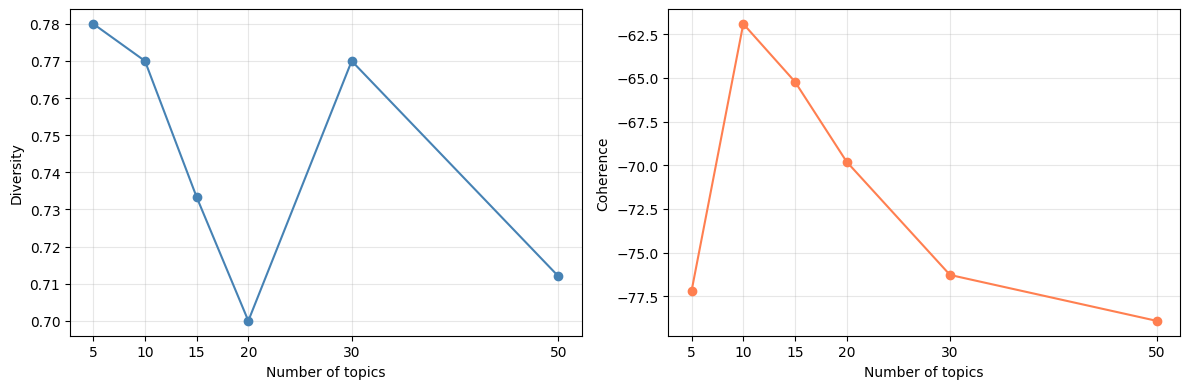


Best diversity: 5 topics (0.7800)
Best coherence: 10 topics (-61.9011)


In [118]:
# Vary the number of topics and find best results
n_topics_list = [5, 10, 15, 20, 30, 50]
results = []

for n_topics in n_topics_list:
    lda_temp = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20)
    lda_temp.fit(train_bow_tm)
    div = topic_diversity(lda_temp.components_)
    coh = umass_coherence(lda_temp.components_, train_bow_binary)
    results.append((div, coh))
    print(f"n_topics={n_topics:2d}: diversity={div:.4f}, coherence={coh:.4f}")

div_scores, coh_scores = zip(*results)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(n_topics_list, div_scores, 'o-', color='steelblue')
ax1.set_xlabel('Number of topics'), ax1.set_ylabel('Diversity')
ax1.grid(True, alpha=0.3), ax1.set_xticks(n_topics_list)

ax2.plot(n_topics_list, coh_scores, 'o-', color='coral')
ax2.set_xlabel('Number of topics'), ax2.set_ylabel('Coherence')
ax2.grid(True, alpha=0.3), ax2.set_xticks(n_topics_list)

plt.tight_layout(), plt.show()

best_div_idx, best_coh_idx = np.argmax(div_scores), np.argmax(coh_scores)
print(f"\nBest diversity: {n_topics_list[best_div_idx]} topics ({div_scores[best_div_idx]:.4f})")
print(f"Best coherence: {n_topics_list[best_coh_idx]} topics ({coh_scores[best_coh_idx]:.4f})")

Investigate using the document representations in **topic space** for the classification task. Search for the best number of topics, performance-wise. Is it the same than before ? 
<div class='alert alert-block alert-info'>
            Code:</div>

In [123]:
from sklearn.linear_model import LogisticRegression

n_topics= 5: accuracy=0.5793
n_topics=10: accuracy=0.6730
n_topics=15: accuracy=0.6845
n_topics=20: accuracy=0.7238
n_topics=30: accuracy=0.7296
n_topics=50: accuracy=0.7221


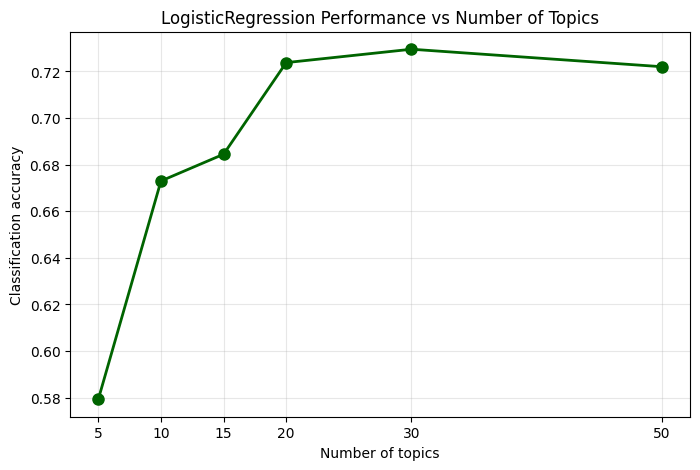


Best for classification (LogisticRegression): 30 topics (accuracy=0.7296)
Comparison:
  - Best diversity: 5 topics
  - Best coherence: 10 topics
  - Best classification: 30 topics

Is it the same? NO - Different from topic quality metrics


In [124]:
# Create consistent BoW representations using the fitted vectorizer
train_bow_consistent = vectorizer.transform(ng_train_text_splt).toarray()
val_bow_consistent = vectorizer.transform(ng_val_text).toarray()

# Classification using LDA topic space representations with LogisticRegression
accs_lr = []

for n_topics in n_topics_list:
    # Fit LDA and transform data to topic space
    lda_temp = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10, mean_change_tol=0.01)
    train_topics = lda_temp.fit_transform(train_bow_consistent)
    val_topics = lda_temp.transform(val_bow_consistent)
    
    # Train LogisticRegression classifier on topic representations
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(train_topics, ng_train_labels_splt)
    acc = clf.score(val_topics, ng_val_labels)
    
    accs_lr.append(acc)
    print(f"n_topics={n_topics:2d}: accuracy={acc:.4f}")

# Plot and find best
best_acc_idx = np.argmax(accs_lr)
best_n_topics_clf = n_topics_list[best_acc_idx]

plt.figure(figsize=(8, 5))
plt.plot(n_topics_list, accs_lr, 'o-', color='darkgreen', linewidth=2, markersize=8)
plt.xlabel('Number of topics'), plt.ylabel('Classification accuracy')
plt.title('LogisticRegression Performance vs Number of Topics'), plt.grid(True, alpha=0.3)
plt.xticks(n_topics_list), plt.show()

print(f"\nBest for classification (LogisticRegression): {best_n_topics_clf} topics (accuracy={accs_lr[best_acc_idx]:.4f})")
print(f"Comparison:")
print(f"  - Best diversity: 5 topics")
print(f"  - Best coherence: 10 topics")
print(f"  - Best classification: {best_n_topics_clf} topics")
print(f"\nIs it the same? {'YES' if best_n_topics_clf in [5, 10] else 'NO - Different from topic quality metrics'}")

In [ ]:
# Expect those results to change with pre-processing